# Twitter data mining

### References

https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/  
https://towardsdatascience.com/mining-twitter-data-ba4e44e6aecc  
https://towardsdatascience.com/@rickykim78  
https://towardsdatascience.com/tweepy-for-beginners-24baf21f2c25  
https://amueller.github.io/word_cloud/auto_examples  


In [1]:
# import sys
# !{sys.executable} -m pip install tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tweepy
import json 
import datetime
import time
import seaborn as sns
import wordcloud

### Login to Twitter API

In [24]:
from auth_ap import *

In [112]:
# Creating the authentication object
auth = tweepy.OAuthHandler(auth_ap.consumer_key, auth_ap.consumer_secret)
# Setting your access token and secret
auth.set_access_token(auth_ap.access_token, auth_ap.access_token_secret)
# Creating the API object while passing in auth information
api = tweepy.API(auth) 

### Explore API

In [113]:
# Using the API object to get tweets from your timeline, and storing it in a variable called public_tweets
public_tweets = api.home_timeline()
# foreach through all tweets pulled
for tweet in public_tweets:
   # printing the text stored inside the tweet object
   print (tweet.text)

Carved out of stone and crushing the hearts of many.

Get the Stoneheart Outfit in the Item Shop now! https://t.co/xB2y7ZMk0k
...If in doubt, ask why the bill withholds $12 billion in highway funds until local authorities agree to federal co… https://t.co/fzL1OxoRyI
Fake News asks why I bring up Booker. It’s because Biden supports Booker’s bill that forces federal control of loca… https://t.co/EDQ8piThil
These are my real words about our GREAT HEROES, not made up lies by the enemy. THANK YOU and God Bless You All! https://t.co/oFgQXzpJHU
Will be interviewed by @SeanHannity tonight at 9:00 P.M. Eastern on @FoxNews. Enjoy!
...These are horrendous people that we must defeat on November 3rd!
...Secret Service would not allow the trip to the cemetery based on very bad weather and security concerns. Now the… https://t.co/0gCGblfGsD
On top of a lie made up by a low-life “reporter”, who is known for disinformation, the Democrats have taken his fal… https://t.co/z7AIdMiq6m
...I’ll take the Endo

What data are available from tweets?

In [21]:
status = tweet
json_str = json.dumps(status._json)

#deserialise string into python object
parsed = json.loads(json_str)

print(json.dumps(parsed, indent=4, sort_keys=True))

{
    "contributors": null,
    "coordinates": null,
    "created_at": "Fri Sep 04 16:01:00 +0000 2020",
    "entities": {
        "hashtags": [],
        "symbols": [],
        "urls": [
            {
                "display_url": "twitter.com/i/web/status/1\u2026",
                "expanded_url": "https://twitter.com/i/web/status/1301913159628992519",
                "indices": [
                    121,
                    144
                ],
                "url": "https://t.co/Ob9OuSezxJ"
            }
        ],
        "user_mentions": [
            {
                "id": 2426189960,
                "id_str": "2426189960",
                "indices": [
                    1,
                    12
                ],
                "name": "Tom Inglesby",
                "screen_name": "T_Inglesby"
            },
            {
                "id": 4289201016,
                "id_str": "4289201016",
                "indices": [
                    19,
                    26


In [19]:
tweet.place

### Miner

In [26]:
class TweetMiner(object):
    import auth_ap
    # number of tweets per one pull; there is limit on this
    result_limit    =   20    
    data            =   []
    api             =   False
    
    twitter_keys = {
        'consumer_key':        auth_ap.consumer_key,
        'consumer_secret':     auth_ap.consumer_secret,
        'access_token_key':    auth_ap.access_token,
        'access_token_secret': auth_ap.access_token_secret
    }
    
    
    def __init__(self, keys_dict=twitter_keys, api=api, result_limit = 20):
        
        self.twitter_keys = keys_dict
        
        auth = tweepy.OAuthHandler(keys_dict['consumer_key'], keys_dict['consumer_secret'])
        auth.set_access_token(keys_dict['access_token_key'], keys_dict['access_token_secret'])
        
        self.api = tweepy.API(auth)
        self.twitter_keys = keys_dict
        
        self.result_limit = result_limit

        
    def tweets_to_dict(self, statuses, incl_retweets = True):
        data = []
        for item in statuses:
            
            mined = {
                'tweet_id':        item.id,
                'name':            item.user.name,
                'screen_name':     item.user.screen_name,            # username
                "followers_count": item.user.followers_count,
                "friends_count":   item.user.friends_count,
                'retweet_count':   item.retweet_count,
                'text':            item.full_text,
                'mined_at':        datetime.datetime.now(),
                'created_at':      item.created_at,
                'favourite_count': item.favorite_count,              # # of likes
                'hashtags':        item.entities['hashtags'],
                'status_count':    item.user.statuses_count,         # # of tweeets
                'location':        item.place,
                'source_device':   item.source
            }
            if incl_retweets:
                try:
                    mined['retweet_text'] = item.retweeted_status.full_text
                except:
                    mined['retweet_text'] = 'None'
                try:
                    mined['quote_text'] = item.quoted_status.full_text
                    mined['quote_screen_name'] = status.quoted_status.user.screen_name
                except:
                    mined['quote_text'] = 'None'
                    mined['quote_screen_name'] = 'None'
            data.append(mined)
        return data, statuses[-1].id
        
    def mine_tweets_user(self, user="",
                         incl_retweets = True, last_tweet_id  =  False,
                         max_pages=17):

        data_page = []
        # keep track of last tweet id
        
        # multiply by the # of result_limit = total tweets
        page           =  1
        
        while page <= max_pages:
            if last_tweet_id:
                statuses   =   self.api.user_timeline(screen_name = user,
                                                     count = self.result_limit,
                                                     # get tweets older than last retrieved ones  
                                                     max_id = last_tweet_id - 1,
                                                     tweet_mode = 'extended',
                                                     include_retweets = incl_retweets
                                                    )        
            else:
                statuses   =   self.api.user_timeline(screen_name=user,
                                                        count = self.result_limit,
                                                        tweet_mode = 'extended',
                                                        include_retweets = incl_retweets)
                
            data, last_tweet_id = self.tweets_to_dict(statuses, incl_retweets)
            # need item to keep track of the last tweet id
            
            
            data_page.extend(data)
            page += 1
        # returns list of dict
        return data_page, last_tweet_id
    
    def mine_tweets_keyword(self, query = "", language = 'en',
                         incl_retweets = True, last_tweet_id  =  False,
                         max_pages=17):

        data_page           =  []
        # keep track of last tweet id
        
        # multiply by the # of result_limit = total tweets
        page           =  1
        
        while page <= max_pages:
            if last_tweet_id:
                statuses   =   self.api.search(q = query, lang = language,
                                                     count = self.result_limit,
                                                     # get tweets older than last retrieved ones  
                                                     max_id = last_tweet_id - 1,
                                                     tweet_mode = 'extended',
                                                     include_retweets = incl_retweets
                                                    )        
            else:
                statuses   =   self.api.search(q = query, lang = language,
                                                        count = self.result_limit,
                                                        tweet_mode = 'extended',
                                                        include_retweets = incl_retweets)
    
    
            data, last_tweet_id = self.tweets_to_dict(statuses, incl_retweets)
            # need item to keep track of the last tweet id
            
#             print (len(data))
            data_page.extend(data)
                
            page += 1
        # returns list of dict
        return data_page, last_tweet_id

In [10]:
last_id = False
miner = TweetMiner(result_limit = 1)
mined_tweets, last_tweet_id = miner.mine_tweets_user(user='nytimes', max_pages = 17, 
                                                         last_tweet_id = last_id, incl_retweets=True)

In [420]:
miner = TweetMiner(result_limit = 5)
last_id = False
for i in range(2):
    
    mined_tweets, last_tweet_id = miner.mine_tweets_user(user='nytimes', max_pages = 17, 
                                                         last_tweet_id = last_id, incl_retweets=True)
    last_id = last_tweet_id
#     mined_tweets_df = pd.DataFrame(mined_tweets)
    print (mined_tweets[0]['retweet_text'])
    print ("last id", last_id)
    break

None
last id 1301667098733805570


In [14]:
mined_tweets[0]

{'tweet_id': 1301978347912691715,
 'name': 'The New York Times',
 'screen_name': 'nytimes',
 'followers_count': 47241202,
 'friends_count': 906,
 'retweet_count': 1,
 'text': 'Facebook is blocking new political ads the week before Election Day. But just how effective could such a move be in minimizing confusion?\n\nThe answer: likely not very effective. https://t.co/EUTevyJaD5',
 'mined_at': datetime.datetime(2020, 9, 4, 16, 21, 1, 679707),
 'created_at': datetime.datetime(2020, 9, 4, 20, 20, 2),
 'favourite_count': 5,
 'hashtags': [],
 'status_count': 406456,
 'location': None,
 'source_device': 'SocialFlow',
 'retweet_text': 'None',
 'quote_text': 'None',
 'quote_screen_name': 'None'}

In [159]:
search_tweets = api.user_timeline('nytimes',count=3,tweet_mode='extended')
for tweet in search_tweets:
    if 'retweeted_status' in tweet._json:
        print(tweet._json['retweeted_status']['full_text'])
    else:
        print(tweet.full_text)

More than a million acres have burned so far in the wildfires across Northern California.

They have claimed at least 6 lives, more than a thousand homes and caused extensive air quality issues.

We're tracking the fires. https://t.co/uGqNEqBA8M
Wrote about how Cribs gave us a giddy peek at the nouveau riche celebrities of the 2000s. And also made "fake it til you make it" the Millennial ethos. https://t.co/b2U0MI0afI
Chadwick Boseman admired “Black Panther” comics since attending Howard University, where he worked at an African bookstore. For the film, he lobbied for characters to have authentic accents and led on-set discussions on African symbolism and spirituality. https://t.co/MoEfzL5AZ3


### Make call every 15 min

In [ ]:
import time

handle_list= ['list of handles you want the timelines of']

twitter_dict={}
counter=0

for name in handle_list:
    try:
      twitter_dict[name]=[]
      twitter_dict[name].append(miner.mine_user_tweets(user=name, max_pages=17))
      counter = counter +1
      if counter%40==0:
        time.sleep(900) #15 minute sleep time
    #if name invalid print name and remove key
    except:
      print(name, 'is invalid or locked')
      twitter_dict.pop(name)
    
all_tweets=pd.concat([pd.DataFrame(twitter_dict[i][0]) for i in twitter_dict])

### Mine by keyword

In [72]:

last_id = False
mined_tweets, last_tweet_id = miner.mine_tweets_keyword(query='AR/VR', language = 'en', 
                               last_tweet_id = last_id, incl_retweets = True, max_pages = 34)

100
100
100
100
100
100
100
90
100
100
100
100
100
100
97
100
98
73
100
100
100
100
100
100
100
89
100
100
100
100
100
100
100
100


In [67]:
len(mined_tweets)

1684

In [81]:
miner = TweetMiner(result_limit = 100)
counter = 1
ls = []
last_id = False
while counter < 15:
    print (counter)
    try:
        
        mined_tweets, last_tweet_id = miner.mine_tweets_keyword(query='AR/VR', language = 'en', 
                                       last_tweet_id = last_id, incl_retweets = True, max_pages = 34)
        last_id = last_tweet_id

        ls.extend(mined_tweets)
    except:
        print ("Limit is reached")
        break
    if i % 4 == 0:
        mined_tweets_df = pd.DataFrame(ls)
        mined_tweets_df.to_pickle("twitter{0}.pkl".format(i))
        time.sleep(16*60) #15 minute sleep time
        print (i)
        ls = []
    counter+=1

1
2
3
4


IndexError: list index out of range

### Get replies to tweets

Try twarc Python package replies  
It might be interesting to look at tweets that got many replies  
What type of tweets get what type of replies?

In [88]:
df_tweets.head()

,created_at,favourite_count,followers_count,friends_count,hashtags,location,mined_at,name,quote_screen_name,quote_text,retweet_count,retweet_text,screen_name,source_device,status_count,text,tweet_id
0,2020-08-29 03:42:13,0,1650,4996,[],None,2020-08-28 23:46:33.617044,John 🚀 VR/AR/MR/XR 🛫 #OCP20 GTC20 (online),None,None,32,"Hey Friends. @CruxXR is hiring talented, fun, ...",chaostheorem,Twitter for Android,14936,RT @Ruffin: Hey Friends. @CruxXR is hiring tal...,1299552913019158528
1,2020-08-29 03:35:41,0,62,503,[],None,2020-08-28 23:46:33.617044,Jorge Rodiles,None,None,6,Good Morning Demons 😈\nAr u ready for having a...,RodilesJorge,Twitter for Android,432,RT @VrDemons: Good Morning Demons 😈\nAr u read...,1299551269363875840
2,2020-08-29 03:33:10,0,51,212,[],None,2020-08-28 23:46:33.617044,iValley Ghana,None,None,1,@VasanAmrutha @iValleyGhana @EducatorsVR @Echo...,iValleyGhana,Twitter for Android,52,RT @TheSmartestGh: @VasanAmrutha @iValleyGhana...,1299550636867026944
3,2020-08-29 03:30:56,0,51,212,"[{'text': 'WealthSecrets', 'indices': [105, 11...",None,2020-08-28 23:46:33.617044,iValley Ghana,None,None,1,Q4.What are the benefits of VR labs in STEM ed...,iValleyGhana,Twitter for Android,52,RT @TheSmartestGh: Q4.What are the benefits of...,1299550074893107200
4,2020-08-29 03:30:24,0,22,3,[],None,2020-08-28 23:46:33.617044,DarthBuzzard,None,None,0,None,DarthBuzzard,Twitter Web App,4474,"@Chris_Maer That's still VR/AR but yeah, it is...",1299549938410565633


In [93]:
# Creating the authentication object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# Setting your access token and secret
auth.set_access_token(access_token, access_token_secret)
# Creating the API object while passing in auth information
api = tweepy.API(auth) 

In [111]:
for idx in range(10000, 10100):    
    user = df_tweets.iloc[idx].screen_name
    tweet_id = df_tweets.iloc[idx].tweet_id
    max_id = None

    replies=[]
    for tweet in tweepy.Cursor(api.search, q='to:' + user, since_id = tweet_id, max_id = max_id, timeout=999999).items(100):
        if hasattr(tweet, 'in_reply_to_status_id_str'):
            if (tweet.in_reply_to_status_id_str==tweet_id):
                replies.append(tweet)
    
    if len(replies) > 0:
        print (len(replies))


TweepError: Twitter error response: status code = 429

In [108]:
df_tweets.iloc[10000]

created_at                                         2020-08-21 21:00:45
favourite_count                                                      0
followers_count                                                    394
friends_count                                                      256
hashtags             [{'text': 'VR', 'indices': [97, 100]}, {'text'...
location                                                          None
mined_at                                    2020-08-28 23:47:36.040526
name                                                    W. Todd Maddox
quote_screen_name                                                 None
quote_text                                                        None
retweet_count                                                        3
retweet_text         🎤 Thank you again to everyone at @HIMSSNYS for...
screen_name                                                wtoddmaddox
source_device                                          Twitter Web App
status

In [95]:
user = tweet.user.screen_name
tweet_id = tweet.id
max_id = None

while True:

    try:
        replies = t.GetSearch(raw_query=q, since_id=tweet_id, max_id=max_id, count=100)
    except twitter.error.TwitterError as e:
        logging.error("caught twitter api error: %s", e)
        time.sleep(60)
        continue
    for reply in replies:
        logging.info("examining: %s" % tweet_url(reply))
        if reply.in_reply_to_status_id == tweet_id:
            logging.info("found reply: %s" % tweet_url(reply))
            yield reply
            # recursive magic to also get the replies to this reply
            for reply_to_reply in get_replies(reply):
                yield reply_to_reply
        max_id = reply.id

0

### Text processing

'Lottem E et al. 2018)\n. Mutations in serotonin transporter (SERT) \nare \nimplicated in various \n32 neurological and neuropsychiatric disorders. \nMouse models with \npartial or full loss of SERT \n33 functionality\n displayed a \nplethora of phenotypes ranging from anxiety to altered \ncortical \n34 development \n(Bengel D et al. 1998; Lira A et al. 2003; Murphy DL and K\n-P Lesch 2008)\n. \n35 Previous research suggests that \n5-\nHT \nplays a\n vital\n role in \nthe sensory\n cortex. \n5-\nHT is \n36 important for the \nremodeling of cortical circuits during development and adulthood. \nVisual cortex \n37 requires both sensory and \nneuromodulator\ny \ninputs, especially during early life, for proper \n38 development \n(Kojic L et al. 2000; Gu Q 2002). Neuromodulators have been shown to regulate \n39 cortical plasticity and sensory processing during the critical period of development and \n40 adulthood \n(Wang Y et al. 1997)\n. \nConsistent with these observations\n, a SERT inhib

In [41]:
from nltk.tokenize import word_tokenize
import re
import operator 
from collections import Counter
from nltk.corpus import stopwords
import string

In [42]:
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=True):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In [112]:
df_tweets.head()

,created_at,favourite_count,followers_count,friends_count,hashtags,location,mined_at,name,quote_screen_name,quote_text,retweet_count,retweet_text,screen_name,source_device,status_count,text,tweet_id
0,2020-08-29 03:42:13,0,1650,4996,[],None,2020-08-28 23:46:33.617044,John 🚀 VR/AR/MR/XR 🛫 #OCP20 GTC20 (online),None,None,32,"Hey Friends. @CruxXR is hiring talented, fun, ...",chaostheorem,Twitter for Android,14936,RT @Ruffin: Hey Friends. @CruxXR is hiring tal...,1299552913019158528
1,2020-08-29 03:35:41,0,62,503,[],None,2020-08-28 23:46:33.617044,Jorge Rodiles,None,None,6,Good Morning Demons 😈\nAr u ready for having a...,RodilesJorge,Twitter for Android,432,RT @VrDemons: Good Morning Demons 😈\nAr u read...,1299551269363875840
2,2020-08-29 03:33:10,0,51,212,[],None,2020-08-28 23:46:33.617044,iValley Ghana,None,None,1,@VasanAmrutha @iValleyGhana @EducatorsVR @Echo...,iValleyGhana,Twitter for Android,52,RT @TheSmartestGh: @VasanAmrutha @iValleyGhana...,1299550636867026944
3,2020-08-29 03:30:56,0,51,212,"[{'text': 'WealthSecrets', 'indices': [105, 11...",None,2020-08-28 23:46:33.617044,iValley Ghana,None,None,1,Q4.What are the benefits of VR labs in STEM ed...,iValleyGhana,Twitter for Android,52,RT @TheSmartestGh: Q4.What are the benefits of...,1299550074893107200
4,2020-08-29 03:30:24,0,22,3,[],None,2020-08-28 23:46:33.617044,DarthBuzzard,None,None,0,None,DarthBuzzard,Twitter Web App,4474,"@Chris_Maer That's still VR/AR but yeah, it is...",1299549938410565633


#### Term frequency

In [43]:
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via', 'vr', 'ar', 
                '#vr', '#ar', "#virtualreality", "#augmentedreality", '’', '#mr', '#ai', '#ml', '#3d',
                '"', 'virtual', 'augmented', "cc", "amp" ]


In [188]:
count_terms = Counter()
count_hash = Counter()
count_users = Counter()
for idx in range(df_tweets.shape[0]):
    text = df_tweets.iloc[idx].retweet_text 
    if text == "None":
        text = df_tweets.iloc[idx].text
    # Create a list with all the terms
#     terms_all = [term for term in preprocess(text) if term not in stop]
    terms_hash = [term for term in preprocess(text) 
              if term not in stop and term.startswith('#')]
    terms_only = [term for term in preprocess(text) 
              if term not in stop and
              not term.startswith(('#', '@'))] 
    users = [term for term in preprocess(text) 
              if term not in stop and term.startswith('@')]
    # Update the counter
    count_users.update(users)
    count_hash.update(terms_hash)
    count_terms.update(terms_only)
    # Print the first 5 most frequent words
print(count_users.most_common(10))
print(count_hash.most_common(10))
print(count_terms.most_common(10))


[('@nicochan33', 880), ('@jblefevre60', 644), ('@mvollmer1', 630), ('@shicooks', 593), ('@margaretsiegien', 527), ('@mikequindazzi', 523), ('@droit_ia', 487), ('@fabriziobustama', 473), ('@enricomolinari', 458), ('@spirosmargaris', 454)]
[('#ai', 2917), ('#iot', 2055), ('#mr', 1087), ('#ml', 893), ('#fintech', 851), ('#digitaltransformation', 831), ('#3d', 774), ('#5g', 759), ('#blockchain', 710), ('#stpiindia', 646)]
[('amp', 1982), ('reality', 1525), ('facebook', 1415), ('new', 1057), ('gt', 1027), ('oculus', 786), ('cc', 733), ('future', 730), ('3', 717), ('labs', 639)]


#### Wordclouds

In [46]:
x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

_input = count_terms
wc = WordCloud( mask = mask, contour_width=3, contour_color= 'steelblue',
                background_color ='white', max_font_size=50, 
                max_words=200, random_state=42, 
                min_font_size = 10).generate_from_frequencies(_input) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 

NameError: name 'WordCloud' is not defined

#### Woedcloud with mask 

In [51]:
from PIL import Image
from wordcloud import WordCloud
path_image = r"C:\Users\Chub_lab\Desktop\V0D-sLDA.jpeg.jpg"
mask = np.array(Image.open(path_image))

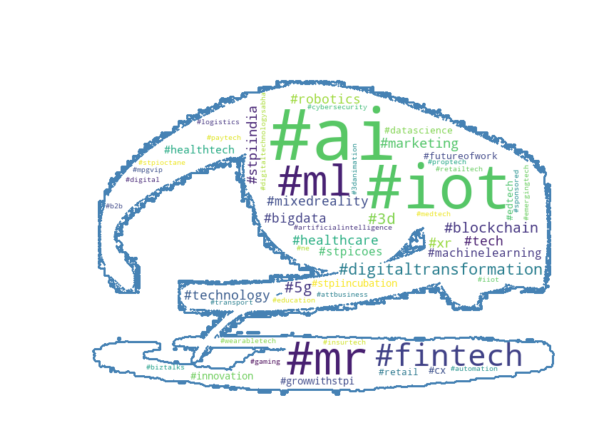

In [311]:
_input = count_hash
wc = WordCloud( mask = mask, contour_width=3, contour_color= 'steelblue',
                background_color ='white', max_font_size=100, 
                max_words=200, random_state=42, 
                min_font_size = 10).generate_from_frequencies(_input) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 

#### Term co-occurrences

In [ ]:
from nltk import bigrams 
count_terms_bigrams = Counter()

for idx in range(df_tweets.shape[0]-1000):
    text = df_tweets.iloc[idx].retweet_text 
    if text == "None":
        text = df_tweets.iloc[idx].text
    # Create a list with all the terms

    terms_only = [term for term in preprocess(text) 
              if term not in stop and
              not term.startswith(('#', '@'))] 
    terms_bigram = bigrams(terms_only)
    # Update the counter
    count_terms_bigrams.update(terms_bigram)
    # Print the first 5 most frequent words
print (count_terms_bigrams.most_common(10))

In [199]:
from collections import defaultdict
# remember to include the other import from the previous post
 
com = defaultdict(lambda : defaultdict(int))
for idx in range(df_tweets.shape[0]):
    text = df_tweets.iloc[idx].retweet_text 
    if text == "None":
        text = df_tweets.iloc[idx].text
    # Create a list with all the terms

    terms_only = [term for term in preprocess(text) 
              if term not in stop and
              not term.startswith(('#', '@'))]  

    # Build co-occurrence matrix
    for i in range(len(terms_only)-1):            
        for j in range(i+1, len(terms_only)):
            w1, w2 = sorted([terms_only[i], terms_only[j]])                
            if w1 != w2:
                com[w1][w2] += 1

In [200]:
com_max = []
# For each term, look for the most common co-occurrent terms
for t1 in com:
    t1_max_terms = sorted(com[t1].items(), key=operator.itemgetter(1), reverse=True)[:5]
    for t2, t2_count in t1_max_terms:
        com_max.append(((t1, t2), t2_count))
# Get the most frequent co-occurrences
terms_max = sorted(com_max, key=operator.itemgetter(1), reverse=True)
print(terms_max[:5])

[(('facebook', 'oculus'), 1337), (('facebook', 'reality'), 1204), (('connect', 'facebook'), 1170), (('facebook', 'labs'), 1120), (('connect', 'oculus'), 1028)]


#### Term freqeuncy over time

In [261]:
my_dict = {}
target_ls = ['#stpiindia', '#fintech', "#blockchain", "#iot"]
for trg in target_ls:
    my_dict[trg] = []

# f is the file pointer to the JSON data set
for idx in range(df_tweets.shape[0]):
    tweet = df_tweets.iloc[idx]
    text = tweet.retweet_text 
    if text == "None":
        text = df_tweets.iloc[idx].text
    # Create a list with all the terms

    terms_only = [term for term in preprocess(text) 
              if term not in stop and
              term.startswith(('#'))]  
    # track when the hashtag is mentioned
    for trg in target_ls: 
        if trg in terms_only:
            my_dict[trg].append(tweet['created_at'])
 


In [262]:
ls = []
for key in my_dict.keys():
    tmp = my_dict[key]
    ones = [1]*len(tmp)
    idx = pd.DatetimeIndex(tmp)
    tmp = pd.Series(ones, index=idx)
    tmp = tmp.resample('30Min').sum().fillna(0).reset_index()
    tmp.columns = ['date', 'freq']
    tmp.loc[:, 'target'] = key
    ls.append(tmp)
df_target_tc = pd.concat(ls)

In [16]:
df_tweet.location

NameError: name 'df_tweet' is not defined

#### Plot tweet frequency over time

In [231]:
from matplotlib.dates import DateFormatter

(array([737659., 737660., 737661., 737662., 737663., 737664., 737665.,
        737666.]), <a list of 8 Text xticklabel objects>)

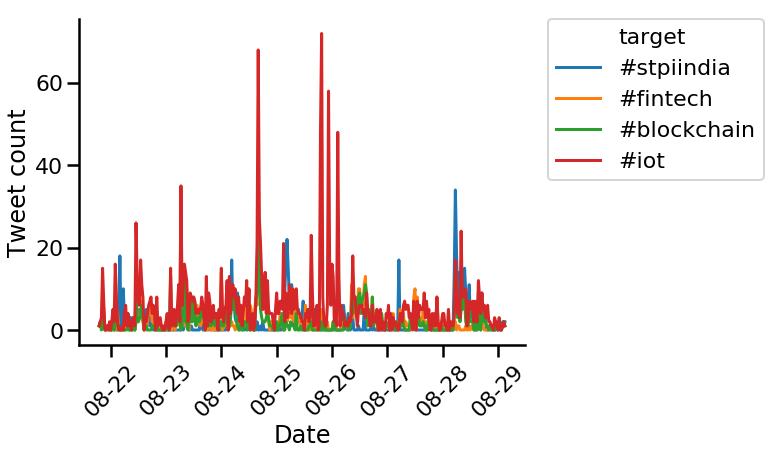

In [270]:
sns.set_context('poster')
f, ax = plt.subplots(figsize =(8, 6))
ax = sns.lineplot(data = df_target_tc, x = 'date', y = 'freq', hue = 'target')
sns.despine()

date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)
ax.set_xlabel('Date')
ax.set_ylabel('Tweet count')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation = 45)

In [244]:
df_freq

,date,freq
0,2020-08-21 23:30:00,1
1,2020-08-22 00:00:00,0
2,2020-08-22 00:30:00,0
3,2020-08-22 01:00:00,1
4,2020-08-22 01:30:00,0
5,2020-08-22 02:00:00,1
6,2020-08-22 02:30:00,0
7,2020-08-22 03:00:00,0
8,2020-08-22 03:30:00,2
9,2020-08-22 04:00:00,18


### Sentiment analysis

In [322]:
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sian = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Chub_lab\AppData\Roaming\nltk_data...


In [326]:
def dict_to_list(dict1):
    dictlist = list()
    for key, value in dict1.items():
        temp = [key,value]
        dictlist.append(temp)
    return dictlist

In [360]:
df_tweets.head()

,created_at,favourite_count,followers_count,friends_count,hashtags,location,mined_at,name,quote_screen_name,quote_text,retweet_count,retweet_text,screen_name,source_device,status_count,text,tweet_id
0,2020-08-29 03:42:13,0,1650,4996,[],None,2020-08-28 23:46:33.617044,John 🚀 VR/AR/MR/XR 🛫 #OCP20 GTC20 (online),None,None,32,"Hey Friends. @CruxXR is hiring talented, fun, ...",chaostheorem,Twitter for Android,14936,RT @Ruffin: Hey Friends. @CruxXR is hiring tal...,1299552913019158528
1,2020-08-29 03:35:41,0,62,503,[],None,2020-08-28 23:46:33.617044,Jorge Rodiles,None,None,6,Good Morning Demons 😈\nAr u ready for having a...,RodilesJorge,Twitter for Android,432,RT @VrDemons: Good Morning Demons 😈\nAr u read...,1299551269363875840
2,2020-08-29 03:33:10,0,51,212,[],None,2020-08-28 23:46:33.617044,iValley Ghana,None,None,1,@VasanAmrutha @iValleyGhana @EducatorsVR @Echo...,iValleyGhana,Twitter for Android,52,RT @TheSmartestGh: @VasanAmrutha @iValleyGhana...,1299550636867026944
3,2020-08-29 03:30:56,0,51,212,"[{'text': 'WealthSecrets', 'indices': [105, 11...",None,2020-08-28 23:46:33.617044,iValley Ghana,None,None,1,Q4.What are the benefits of VR labs in STEM ed...,iValleyGhana,Twitter for Android,52,RT @TheSmartestGh: Q4.What are the benefits of...,1299550074893107200
4,2020-08-29 03:30:24,0,22,3,[],None,2020-08-28 23:46:33.617044,DarthBuzzard,None,None,0,None,DarthBuzzard,Twitter Web App,4474,"@Chris_Maer That's still VR/AR but yeah, it is...",1299549938410565633


In [364]:
d_compound

{1299552913019158528: 0.9642,
 1299551269363875840: 0.8942,
 1299550636867026944: 0.743,
 1299550074893107200: 0.3818,
 1299549938410565633: 0.4215,
 1299549397257084928: 0.5574,
 1299549088212553731: -0.3382,
 1299548535961116672: 0.0,
 1299547916592443392: 0.0,
 1299547904785494017: 0.3818,
 1299547609338720261: 0.0,
 1299547305377366017: 0.7777,
 1299546463484047360: 0.0,
 1299545221475098624: -0.1759,
 1299544938435063810: 0.25,
 1299544744595390465: 0.0,
 1299543843096924160: 0.0,
 1299542632314449921: 0.0,
 1299542355738058752: 0.0,
 1299541764529766401: 0.0,
 1299541654395916294: -0.4588,
 1299541453673242624: 0.4019,
 1299541109924917248: 0.9642,
 1299540361757356034: 0.0,
 1299540276265050117: 0.0,
 1299538555581222912: 0.4215,
 1299537770747105281: 0.717,
 1299537157049245697: 0.0,
 1299536508941225985: 0.0,
 1299536114160672768: -0.4588,
 1299536053032767489: 0.0,
 1299535106688811011: 0.0,
 1299533405785264129: 0.7176,
 1299533342543618049: -0.4588,
 1299533312164126720: 0.

In [363]:
d_compound = {}
tweet_sentim = []
for idx in range(df_tweets.shape[0]):
    text = df_tweets.iloc[idx].retweet_text 
    if text == "None":
        text = df_tweets.iloc[idx].text
    tweet_id = df_tweets.iloc[idx].tweet_id
    d_compound[tweet_id] = sian.polarity_scores(text)['compound']
#     dict_res = dict_to_list(sian.polarity_scores(text))
    #nltk.sentiment.util.demo_vader_instance(_)
#     tweet_sentim.append([text, dict_res[0][1], dict_res[1][1], dict_res[2][1], dict_res[3][1]])

# df_sentim = pd.DataFrame(tweet_sentim)
# df_sentim.columns = ['text', 'neg', 'neu', 'pos', 'compound']
# df_sentim.head()

from https://github.com/cjhutto/vaderSentiment  
    The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

    It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

        positive sentiment: compound score >= 0.05
        neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
        negative sentiment: compound score <= -0.05



In [330]:
df_sentim = df_sentim.drop_duplicates()
df_sentim = df_sentim.sort_values(['compound'], ascending=False)
df_sentim.head()

,text,neg,neu,pos,compound
739,VR + Trial biking on the edge = WOAH! 🤯\n\nAlw...,0.000,0.609,0.391,0.9712
7211,Few new technologies have inspired as much exc...,0.000,0.590,0.410,0.9705
1481,"Hey Friends. @CruxXR is hiring talented, fun, ...",0.029,0.548,0.423,0.9642
9307,This years @places_festival was different but ...,0.000,0.694,0.306,0.9603
9500,"Wishing a beautiful, colorful and cheerful #Ga...",0.000,0.585,0.415,0.9595


In [359]:
df_sentim.head()

,text,neg,neu,pos,compound
739,VR + Trial biking on the edge = WOAH! 🤯\n\nAlw...,0.000,0.609,0.391,0.9712
7211,Few new technologies have inspired as much exc...,0.000,0.590,0.410,0.9705
1481,"Hey Friends. @CruxXR is hiring talented, fun, ...",0.029,0.548,0.423,0.9642
9307,This years @places_festival was different but ...,0.000,0.694,0.306,0.9603
9500,"Wishing a beautiful, colorful and cheerful #Ga...",0.000,0.585,0.415,0.9595


In [406]:
for i in range(5):
    text = df_sentim[df_sentim['compound'] < -0.5].iloc[i].text
    print (text)

⚡ #Facebook angers #Oculus #VR owners with #Facebook login requirement https://t.co/MTNedPTuHi #ar
@ATTBusiness lowering the barriers to entry is critical if we are to see mass adoption and uptake

@dez_blanchfield #Sponsored #ATTBusiness #BizTalks #5G #AI #ML #IoT #Retail #HealthCare #Transport #Logistics #AR #VR #B2B
@Sparshparihar1 @iRohitChoudhary @manilajamwal Here are some to start with Sparsh :

Agro foods  
Digital Healthcare
Supply chain management
E waste management
Food processing
Hydroponics
Co-working
Hyperlocal challanges
AR/ VR in tourism
On demand services
and much more... 

Check startupindia and Yourstory website
No no square in beat saber 😂
juicyfruitsnacks @joshdubgaming 

#virtualreality #vr #d #augmentedreality #oculus #gaming #technology #ar #htcvive #oculusrift #virtualrealitygames #virtual #virtualrealityworld… https://t.co/PJCVpmfHxP
Virtual &amp; Remote work is real. 
#AR #VR #XR #MR 
#Robotics #Mechatronics #STEM #TECH is king in the new reset. 
We missed yo

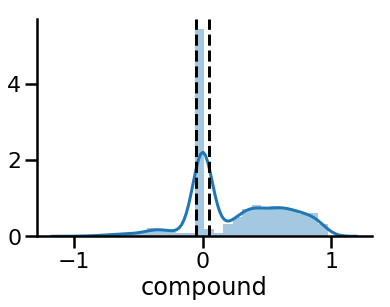

In [348]:
sns.distplot(df_sentim['compound'])
sns.despine()
plt.axvline(x = -0.05, linestyle = '--', color = 'k')
plt.axvline(x = 0.05, linestyle = '--', color = 'k')

In [365]:
df_tweets.loc[:, 'compound'] = df_tweets.tweet_id.map(d_compound)

In [388]:
src_dev = df_tweets.groupby(['source_device']).tweet_id.count().reset_index()
toi = src_dev[src_dev.tweet_id > 100].source_device.unique()


,count,mean,std,min,25%,50%,75%,max
source_device,,,,,,,,
,129.0,0.189136,0.329611,-0.8001,0.0,0.0000,0.51060,0.9097
Buffer,184.0,0.214216,0.317170,-0.6808,0.0,0.0000,0.51060,0.9016
Hootsuite Inc.,209.0,0.224292,0.352091,-0.6369,0.0,0.0000,0.46050,0.9360
IFTTT,125.0,0.122254,0.271883,-0.3818,0.0,0.0000,0.20230,0.9244
TweetDeck,225.0,0.297185,0.347033,-0.6399,0.0,0.3182,0.59600,0.9442
Twitter Web App,3123.0,0.264332,0.348881,-0.9151,0.0,0.2023,0.56100,0.9712
Twitter for Android,2441.0,0.262137,0.355362,-0.9178,0.0,0.0000,0.57190,0.9705
Twitter for iPad,194.0,0.206097,0.345465,-0.7351,0.0,0.0000,0.48925,0.9485
Twitter for iPhone,1728.0,0.257190,0.365951,-0.9460,0.0,0.0772,0.57190,0.9705


Does the soruce device correlate with senimnet polarity?

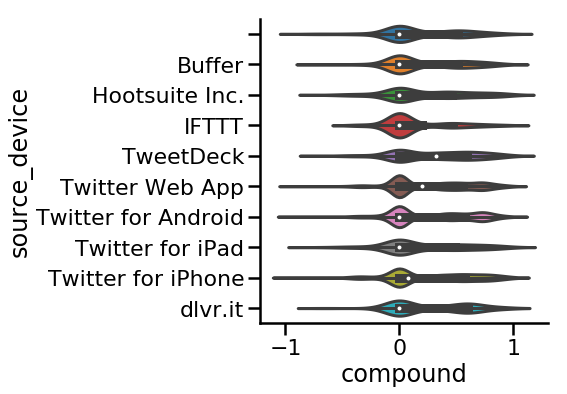

In [405]:
_input = df_tweets[df_tweets.source_device.isin(toi)].sort_values(by = ['source_device'])
sns.catplot(data = _input, y = 'source_device', x = 'compound', kind = 'violin',
           height = 6, aspect = 1.4, orient = 'h')
# plt.xticks(rotation= 30)

In [409]:
df_tweets.head()

,created_at,favourite_count,followers_count,friends_count,hashtags,location,mined_at,name,quote_screen_name,quote_text,retweet_count,retweet_text,screen_name,source_device,status_count,text,tweet_id,compound
0,2020-08-29 03:42:13,0,1650,4996,[],None,2020-08-28 23:46:33.617044,John 🚀 VR/AR/MR/XR 🛫 #OCP20 GTC20 (online),None,None,32,"Hey Friends. @CruxXR is hiring talented, fun, ...",chaostheorem,Twitter for Android,14936,RT @Ruffin: Hey Friends. @CruxXR is hiring tal...,1299552913019158528,0.9642
1,2020-08-29 03:35:41,0,62,503,[],None,2020-08-28 23:46:33.617044,Jorge Rodiles,None,None,6,Good Morning Demons 😈\nAr u ready for having a...,RodilesJorge,Twitter for Android,432,RT @VrDemons: Good Morning Demons 😈\nAr u read...,1299551269363875840,0.8942
2,2020-08-29 03:33:10,0,51,212,[],None,2020-08-28 23:46:33.617044,iValley Ghana,None,None,1,@VasanAmrutha @iValleyGhana @EducatorsVR @Echo...,iValleyGhana,Twitter for Android,52,RT @TheSmartestGh: @VasanAmrutha @iValleyGhana...,1299550636867026944,0.7430
3,2020-08-29 03:30:56,0,51,212,"[{'text': 'WealthSecrets', 'indices': [105, 11...",None,2020-08-28 23:46:33.617044,iValley Ghana,None,None,1,Q4.What are the benefits of VR labs in STEM ed...,iValleyGhana,Twitter for Android,52,RT @TheSmartestGh: Q4.What are the benefits of...,1299550074893107200,0.3818
4,2020-08-29 03:30:24,0,22,3,[],None,2020-08-28 23:46:33.617044,DarthBuzzard,None,None,0,None,DarthBuzzard,Twitter Web App,4474,"@Chris_Maer That's still VR/AR but yeah, it is...",1299549938410565633,0.4215


#### Cluster users by bio

It is better to save tweets to .json and load what you need for the analysis 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

def get_parser():
    parser = ArgumentParser("Clustering for followers")
    parser.add_argument('--filename') 
    parser.add_argument('--k', type=int) 
    parser.add_argument('--min-df', type=int, default=2) 
    parser.add_argument('--max-df', type=float, default=0.8) 
    parser.add_argument('--max-features', type=int, default=None) 
    parser.add_argument('--no-idf', dest='user_idf', default=True, action='store_false') 
    parser.add_argument('--min-ngram', type=int, default=1) 
    parser.add_argument('--max-ngram', type=int, default=1) 
    return parserif __name__ == '__main__':
    parser = get_parser()
    args = parser.parse_args()
    if args.min_ngram > args.max_ngram:
        print("Error: incorrect value for --min--ngram ({}): it cant be higher than \
        --max--value ({})".format(args.min_ngram, args.max_ngram))
        sys.exit(1)
    with open(args.filename) as f:
        #load datausers = []
        for line in f:
            profile = json.loads(line)
            users.append(profile['description'])
        #create vectorizer
        vectorizer = TfidfVectorizer(max_df=args.max_df,
                                    min_df=args.min_df,
                                    max_features=args.max_features,
                                    stop_words='english',
                                    ngram_range=(args.min_ngram, args.max_ngram),
                                    use_idf=args.user_idf)#fit data
        X = vectorizer.fit_transform(users)
        print("Data dimensions: {}".format(X.shape))#perform clustering
        km = KMeans(n_clusters=args.k)
        km.fit(X)
        clusters = defaultdict(list)
        for i, label in enumerate(km.labels_):
            clusters[label].append(users[i])#print 10 user description of this clusterfor label, description in clusters.items():
            print("--------- Cluster {}".format(label+i))
            for desc in description[:10]:
                print(desc)